In [2]:
# Python libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import itertools
from itertools import chain
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve, train_test_split
from sklearn.metrics import precision_score, recall_score, confusion_matrix, roc_curve, precision_recall_curve, accuracy_score
import warnings
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff

warnings.filterwarnings('ignore') #ignore warning messages 

In [3]:
from sklearn.ensemble import RandomForestClassifier #for the model
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz #plot tree
from sklearn.metrics import roc_curve, auc #for model evaluation
from sklearn.metrics import classification_report #for model evaluation
from sklearn.metrics import confusion_matrix #for model evaluation
from sklearn.model_selection import train_test_split #for data splitting

In [4]:
# Read data
data = pd.read_csv('所有记录结果汇总.csv')

In [5]:
# 删掉无效列
data = data.drop(['graph_name'],axis = 1)

In [6]:
#对标签列编码
data.balance[data.balance==True]=1
data.balance[data.balance==False]=0
data.head()

,balance,number_of_nodes,number_of_edges,node_of_max_density_subgraph,average_clustering,degree_assortativity_coefficient,local_efficiency,global_efficiency,diameter,average_shortest_path_length,wiener_index
0,1.0,622,1576,0.500000,0.073591,0.239491,0.080091,0.224449,10,5.072117,979583.0
1,0.0,492,1560,0.142276,0.051066,0.155154,0.070599,0.277392,8,3.993112,482312.0
2,1.0,689,1748,0.499274,0.038855,0.223643,0.042929,0.225858,9,4.974875,1179125.0
3,0.0,856,2963,0.056075,0.062150,0.295119,0.084243,0.231464,10,4.885170,1787679.0
4,1.0,764,1545,0.862565,0.033095,-0.103863,0.033881,0.191380,11,5.871848,1711444.0


In [143]:
# 将两类数据分别放入对应的变量
B = data[(data['balance'] == 1)]
UB = data[(data['balance'] == 0)]

#计算两类记录的数量（条形图）以及占比（饼图）
#------------COUNT-----------------------
trace = go.Bar(x = (len(B), len(UB)), y = ['balanced', 'unbalanced'], orientation = 'h', opacity = 0.8, marker=dict(
        color=[ 'gold', 'lightskyblue'],
        line=dict(color='#000000',width=1.5)))

layout = dict(title =  'Count')
                    
fig = dict(data = [trace], layout=layout)
py.iplot(fig)

## 特征相关性查看

In [8]:
#查看相关性大小
#correlation （查看特征、标签之间两两的相关性大小）
correlation = data.corr()
#tick labels
matrix_cols = correlation.columns.tolist()
#convert to array
corr_array  = np.array(correlation)

#Plotting
trace = go.Heatmap(z = corr_array,
                   x = matrix_cols,
                   y = matrix_cols,
                   xgap = 2,
                   ygap = 2,
                   colorscale='Viridis',
                   colorbar   = dict() ,
                  )
layout = go.Layout(dict(title = 'Correlation Matrix for variables',
                        autosize = False,
                        height  = 720,
                        width   = 800,
                        margin  = dict(r = 0 ,l = 210,
                                       t = 25,b = 210,
                                     ),
                        yaxis   = dict(tickfont = dict(size = 9)),
                        xaxis   = dict(tickfont = dict(size = 9)),
                       )
                  )
fig = go.Figure(data = [trace],layout = layout)
py.iplot(fig)

## 数据划分

In [10]:
#划分数据集，得到训练、测试集，其中训练：测试样本占比为8:2
X_train, X_test, y_train, y_test = train_test_split(data.drop('balance', 1), data['balance'], test_size = .2, random_state=10) 

In [7]:
#只保留相关性较强强的特征
dt_5=data[['balance','node_of_max_density_subgraph','degree_assortativity_coefficient','wiener_index','number_of_nodes','average_clustering']]
X_train5, X_test5, y_train5, y_test5 = train_test_split(dt_5.drop('balance', 1), dt_5['balance'], test_size = .2, random_state=10) 

## 模型训练

### 1 用随机森林对所有特征列进行分类

In [13]:
#模型训练
RandomForest_all = RandomForestClassifier(max_depth=5)
RandomForest_all.fit(X_train, y_train)

#代入测试集进行预测
y_predict = RandomForest_all.predict(X_test) #预测值
# model.predict_proba返回的是一个 n 行 k 列的数组， 第 i 行 第 j 列上的数值是模型预测 第 i 个预测样本为某个标签的概率，并且每一行的概率和为1
y_pred_quant =RandomForest_all.predict_proba(X_test)[:, 1] #即模型预测样本为患病的概率
y_pred_bin = RandomForest_all.predict(X_test)

In [14]:
#绘制混淆矩阵，将预测结果与真实值进行对比
cm = confusion_matrix(y_test, y_pred_bin)
cm

array([[106,  11],
       [  6,  86]])

In [16]:
#指标计算
total=sum(sum(cm))

precision = (cm[1,1]+cm[0,0])/total
print('precision: ', precision)

precision:  0.9186602870813397


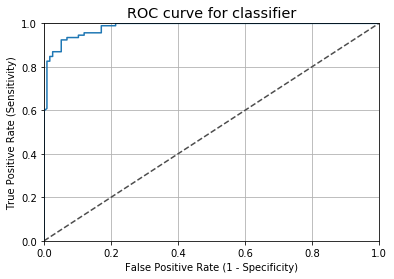

In [17]:
#ROC曲线绘制
fpr, tpr, thresholds = roc_curve(y_test, y_pred_quant)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

## lOGISTIC +RFE

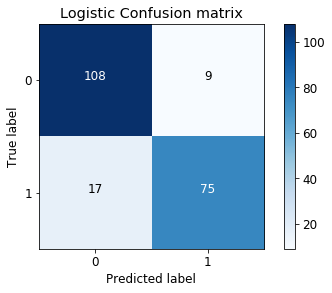

Accuracy  =     0.876
Precision =     0.893
Recall    =     0.815
F1_score  =     0.852


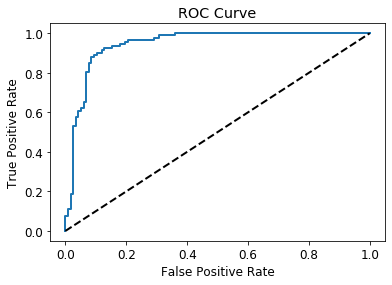

In [155]:
#Logistic regression with RFE
log_clf = LogisticRegression(C = best_parameters['C'], 
                                 penalty = best_parameters['penalty'], 
                                 random_state = random_state)

selector = RFE(log_clf)
selector = selector.fit(X_train, y_train)

y_pred = selector.predict(X_test)
y_score = selector.predict_proba(X_test)[:,1]


# Confusion maxtrix & metrics
cm = confusion_matrix(y_test, y_pred)
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cm, 
                      classes=class_names, 
                      title='Logistic Confusion matrix')
plt.show()

show_metrics()

# ROC curve
fpr, tpr, t = roc_curve(y_test, y_score)
plot_roc()

## 评价指标计算

In [15]:
# Confusion matrix 
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion matrix"',
                          cmap = plt.cm.Blues) :
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title,fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 0,size=20)
    plt.yticks(tick_marks, classes,size=20)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])) :
        plt.text(j, i, cm[i, j],
                 horizontalalignment = 'center',fontsize=20,
                 color = 'white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True label',fontsize=20)
    plt.xlabel('Predicted label',fontsize=20)
    
# Show metrics 
def show_metrics():
    tp = cm[1,1]
    fn = cm[1,0]
    fp = cm[0,1]
    tn = cm[0,0]
    print('Accuracy  =     {:.3f}'.format((tp+tn)/(tp+tn+fp+fn)))
    print('Precision =     {:.3f}'.format(tp/(tp+fp)))
    print('Recall    =     {:.3f}'.format(tp/(tp+fn)))
    print('F1_score  =     {:.3f}'.format(2*(((tp/(tp+fp))*(tp/(tp+fn)))/
                                                 ((tp/(tp+fp))+(tp/(tp+fn))))))

# ROC curve
def plot_roc():
    plt.plot(fpr, tpr, label = 'ROC curve', linewidth = 2)
    plt.plot([0,1],[0,1], 'k--', linewidth = 2)
   # plt.xlim([0.0,0.001])
   # plt.ylim([0.0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show();

## 2 选取相关性最大的top5特征+random forest

In [162]:
#模型训练
RandomForest_5 = RandomForestClassifier(max_depth=4)
RandomForest_5.fit(X_train5, y_train5)

#代入测试集进行预测
y_predict5 = RandomForest_5.predict(X_test5) #预测值
# model.predict_proba返回的是一个 n 行 k 列的数组， 第 i 行 第 j 列上的数值是模型预测 第 i 个预测样本为某个标签的概率，并且每一行的概率和为1
y_pred_quant =RandomForest_5.predict_proba(X_test5)[:, 1] #即模型预测样本为患病的概率
y_pred_bin = RandomForest_5.predict(X_test5)

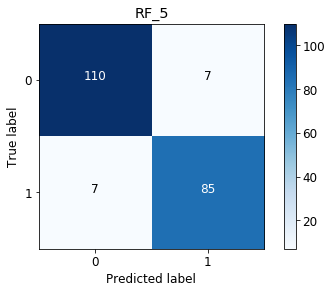

Accuracy  =     0.933
Precision =     0.924
Recall    =     0.924
F1_score  =     0.924


In [163]:
# Confusion maxtrix & metrics
cm = confusion_matrix(y_test5, y_predict5)
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cm, 
                      classes=class_names, 
                      title='RF_5')
plt.savefig('6')
plt.show()

show_metrics()


## 3 选取相关性最大的top5特征+ LOGISTIC+网格逼近

In [164]:
#网格逼近寻优超参数+logistics分类

random_state=42
# Find best hyperparameters (accuracy)
log_clf = LogisticRegression(random_state = random_state)
param_grid = {
            'penalty' : ['l2','l1'],  
            'C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000]
            }

CV_log_clf = GridSearchCV(estimator = log_clf, param_grid = param_grid , scoring = 'accuracy', verbose = 1, n_jobs = -1)
CV_log_clf.fit(X_train5, y_train5)

best_parameters = CV_log_clf.best_params_
print('The best parameters for using this model is', best_parameters)

Fitting 3 folds for each of 14 candidates, totalling 42 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


The best parameters for using this model is {'C': 10, 'penalty': 'l1'}


[Parallel(n_jobs=-1)]: Done  42 out of  42 | elapsed:    2.9s finished


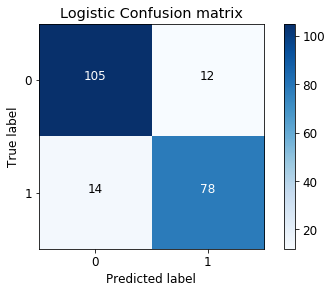

Accuracy  =     0.876
Precision =     0.867
Recall    =     0.848
F1_score  =     0.857


In [166]:
# 用测试得出的最优超参数进行回归预测
CV_log_clf5 = LogisticRegression(C = best_parameters['C'], 
                                penalty = best_parameters['penalty'], 
                                random_state = random_state)

CV_log_clf5.fit(X_train5, y_train5)
y_pred = CV_log_clf5.predict(X_test5)
y_score = CV_log_clf5.decision_function(X_test5)

# 用测试得出的最优超参数进行回归预测
CV_log_clf5 = LogisticRegression(C = best_parameters['C'], 
                                penalty = best_parameters['penalty'], 
                                random_state = random_state)

CV_log_clf5.fit(X_train5, y_train5)
y_pred5= CV_log_clf.predict(X_test5)
y_score5 = CV_log_clf.decision_function(X_test5)

# Confusion maxtrix & metrics
cm = confusion_matrix(y_test5, y_pred5)
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cm, 
                      classes=class_names, 
                      title='Logistic Confusion matrix')
plt.savefig('6')
plt.show()

show_metrics()

## 4 5个特征+decisionTree

In [130]:
# Decision Tree Classifier  
def decision_tree_classifier(train_x, train_y):  
    from sklearn import tree  
    model = tree.DecisionTreeClassifier()  
    model.fit(train_x, train_y)  
    return model  

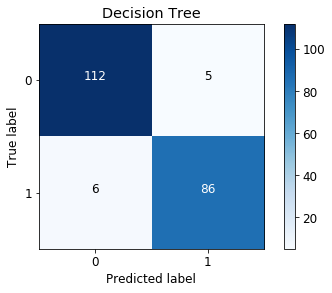

Accuracy  =     0.947
Precision =     0.945
Recall    =     0.935
F1_score  =     0.940


In [167]:
DT5=decision_tree_classifier(X_train5, y_train5)
y_pred5 = DT5.predict(X_test5)

# Confusion maxtrix & metrics
cm = confusion_matrix(y_test5, y_pred5)
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cm, 
                      classes=class_names, 
                      title='Decision Tree')
plt.savefig('6')
plt.show()

show_metrics()

## 5个特征+svm

In [153]:
# SVM Classifier using cross validation  

from sklearn import metrics  
def svm_classifier(train_x, train_y):  
    from sklearn.svm import SVC  
    model = SVC(kernel='rbf', probability=True)  
    model.fit(train_x, train_y)  
    return model

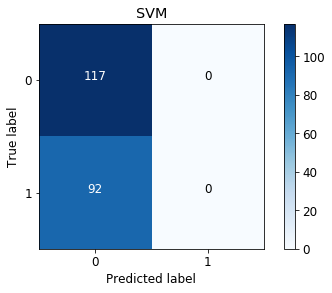

Accuracy  =     0.560
Precision =     nan
Recall    =     0.000
F1_score  =     nan


In [168]:
SVM5=svm_classifier(X_train5, y_train5)
y_pred5 = SVM5.predict(X_test5)

# Confusion maxtrix & metrics
cm = confusion_matrix(y_test5, y_pred5)
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cm, 
                      classes=class_names, 
                      title='SVM')
plt.savefig('6')
plt.show()

show_metrics()

## 6 knn+5个特征

In [111]:
# KNN Classifier  
def knn_classifier(train_x, train_y):  
    from sklearn.neighbors import KNeighborsClassifier  
    model = KNeighborsClassifier()  
    model.fit(train_x, train_y)  
    return model 

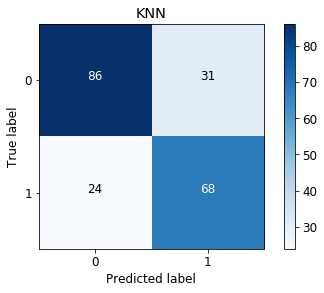

Accuracy  =     0.737
Precision =     0.687
Recall    =     0.739
F1_score  =     0.712


In [169]:
KNN5=knn_classifier(X_train5, y_train5)
y_pred5 = KNN5.predict(X_test5)

# Confusion maxtrix & metrics
cm = confusion_matrix(y_test5, y_pred5)
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cm, 
                      classes=class_names, 
                      title='KNN')
plt.savefig('6')
plt.show()

show_metrics()

## 7 GBDT+5 features

In [9]:
# GBDT(Gradient Boosting Decision Tree) Classifier  
def gradient_boosting_classifier(train_x, train_y):  
    from sklearn.ensemble import GradientBoostingClassifier  
    model = GradientBoostingClassifier(max_depth=3,n_estimators=200)  
    model.fit(train_x, train_y)  
    return model

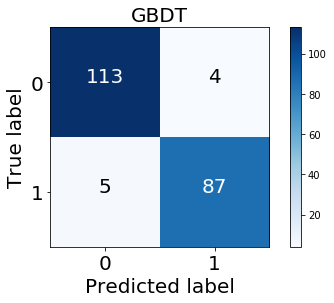

Accuracy  =     0.957
Precision =     0.956
Recall    =     0.946
F1_score  =     0.951


In [16]:
GBDT5=gradient_boosting_classifier(X_train5, y_train5)
y_pred5 = GBDT5.predict(X_test5)

# Confusion maxtrix & metrics
cm = confusion_matrix(y_test5, y_pred5)
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cm, 
                      classes=class_names, 
                      title='GBDT')
plt.savefig('6')
plt.show()

show_metrics()

## 神经网络+5个特征

In [95]:
from keras.models import Sequential
from keras.layers import Dense, Dropout,Activation
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import LabelEncoder

In [105]:
# define model structure
def baseline_model():
    model = Sequential()
    
    # 第一隐藏层的配置：输入784，输出100
    model.add(Dense(10,input_dim=5))
    model.add(Activation("sigmoid"))
    model.add(Dropout(0.5))
    
    # 第二隐藏层的配置：输入100，输出100
    model.add(Dense(5))
    model.add(Activation("sigmoid"))
    model.add(Dropout(0.5))

    # 输出层的配置：输入100，输出10，用了softmax的输出层结构
    model.add(Dense(2))
    model.add(Activation("sigmoid"))
    
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])
    return model

In [64]:
# encode class values as integers
encoder = LabelEncoder()
encoded_Y = encoder.fit_transform(data['balance'])
# convert integers to dummy variables (one hot encoding)
dummy_y = np_utils.to_categorical(encoded_Y)

In [66]:
# splitting data into training set and test set. If random_state is set to an integer, the split datasets are fixed.
X_train3, X_test3, Y_train3, Y_test3 = train_test_split(dt_5.drop('balance', 1), dummy_y, test_size=0.3, random_state=0)

In [106]:
estimator = KerasClassifier(build_fn=baseline_model, epochs=5, batch_size=100)
# splitting data into training set and test set. If random_state is set to an integer, the split datasets are fixed.
estimator.fit(X_train3, Y_train3)

Epoch 1/5
729/729 [==============================] - 2s 2ms/step - loss: 0.7365 - acc: 0.5130
Epoch 2/5
729/729 [==============================] - 0s 35us/step - loss: 0.7448 - acc: 0.4856
Epoch 3/5
729/729 [==============================] - 0s 39us/step - loss: 0.7323 - acc: 0.5103
Epoch 4/5
729/729 [==============================] - 0s 40us/step - loss: 0.7396 - acc: 0.5034
Epoch 5/5
729/729 [==============================] - 0s 39us/step - loss: 0.7276 - acc: 0.5185


In [91]:
# make predictions
pred = estimator.predict(X_test3)

## 模型评价

### permutation importance

In [203]:
import eli5 #for purmutation importance
from eli5.sklearn import PermutationImportance
import shap #for SHAP values
from pdpbox import pdp, info_plots #for partial plots

In [206]:
perm = PermutationImportance(GBDT5, random_state=1).fit(X_test5, y_test5)
eli5.show_weights(perm, feature_names = X_test5.columns.tolist())

Weight,Feature
0.2861 ± 0.0186,node_of_max_density_subgraph
0.0507 ± 0.0294,degree_assortativity_coefficient
0.0191 ± 0.0135,wiener_index
0.0144 ± 0.0250,average_clustering
0.0067 ± 0.0223,number_of_nodes


### pdp

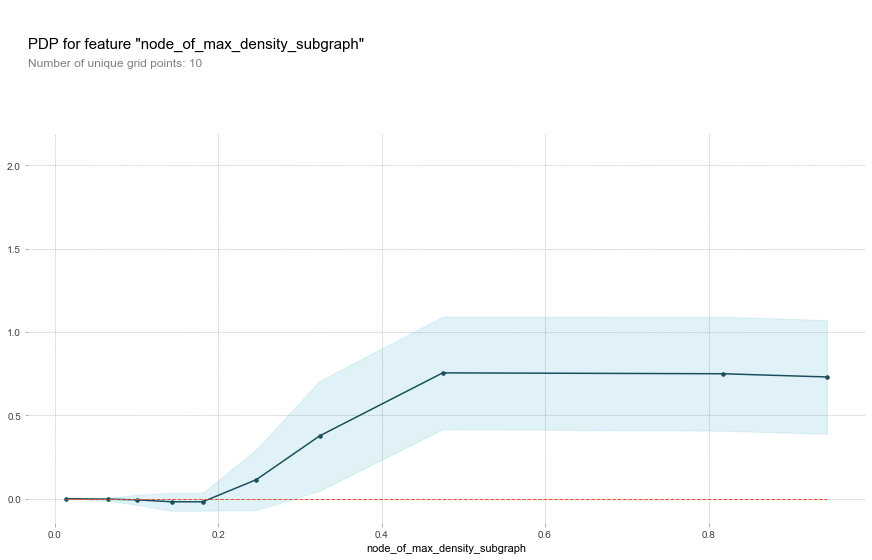

In [208]:
#对单个特征查看其局部依赖
base_features = dt_5.columns.values.tolist()
base_features.remove('balance')

feat_name = 'node_of_max_density_subgraph'
pdp_dist = pdp.pdp_isolate(model=GBDT5, dataset=X_test5, model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

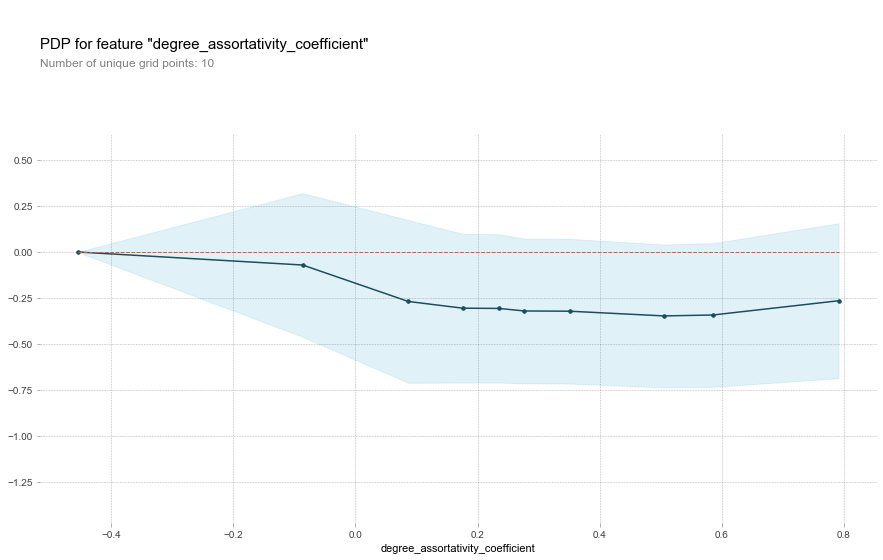

In [209]:
#对单个特征查看其局部依赖
base_features = dt_5.columns.values.tolist()
base_features.remove('balance')

feat_name = 'degree_assortativity_coefficient'
pdp_dist = pdp.pdp_isolate(model=GBDT5, dataset=X_test5, model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

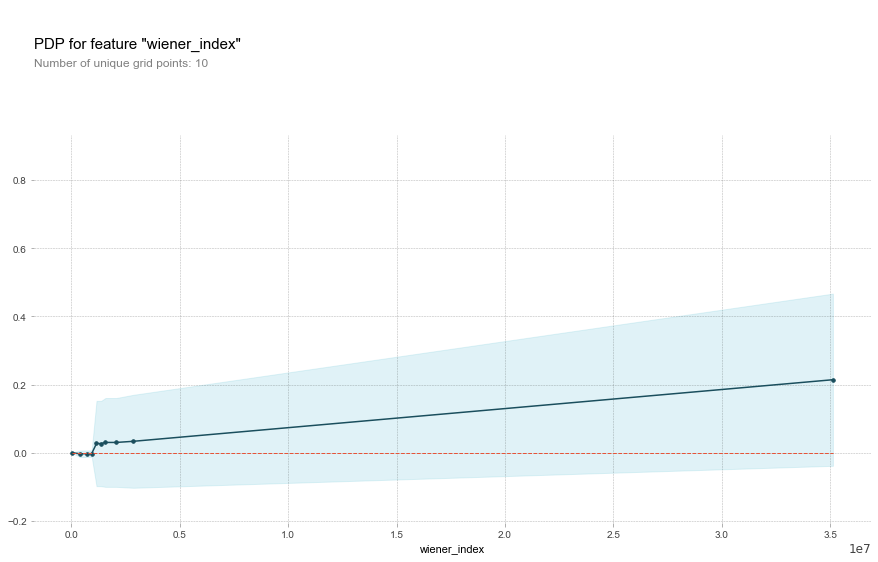

In [210]:
#对单个特征查看其局部依赖
base_features = dt_5.columns.values.tolist()
base_features.remove('balance')

feat_name = 'wiener_index'
pdp_dist = pdp.pdp_isolate(model=GBDT5, dataset=X_test5, model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

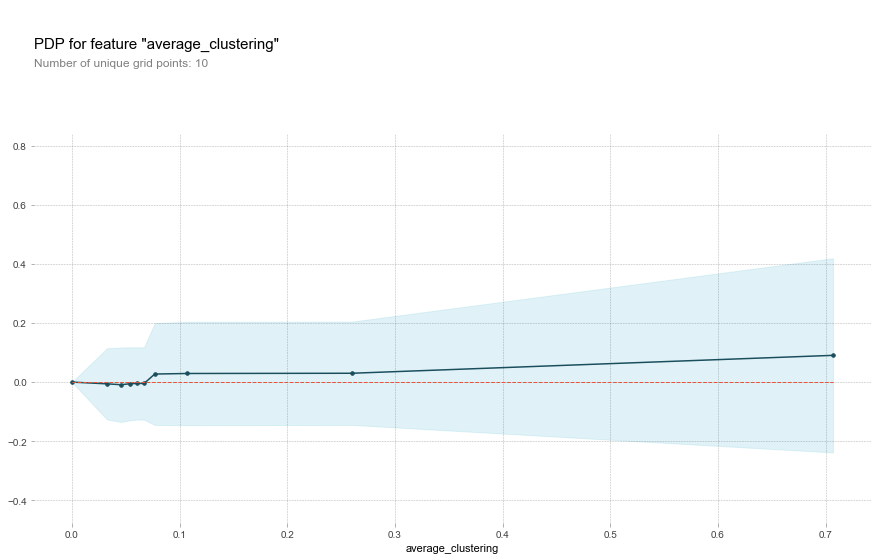

In [211]:
#对单个特征查看其局部依赖
base_features = dt_5.columns.values.tolist()
base_features.remove('balance')

feat_name = 'average_clustering'
pdp_dist = pdp.pdp_isolate(model=GBDT5, dataset=X_test5, model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

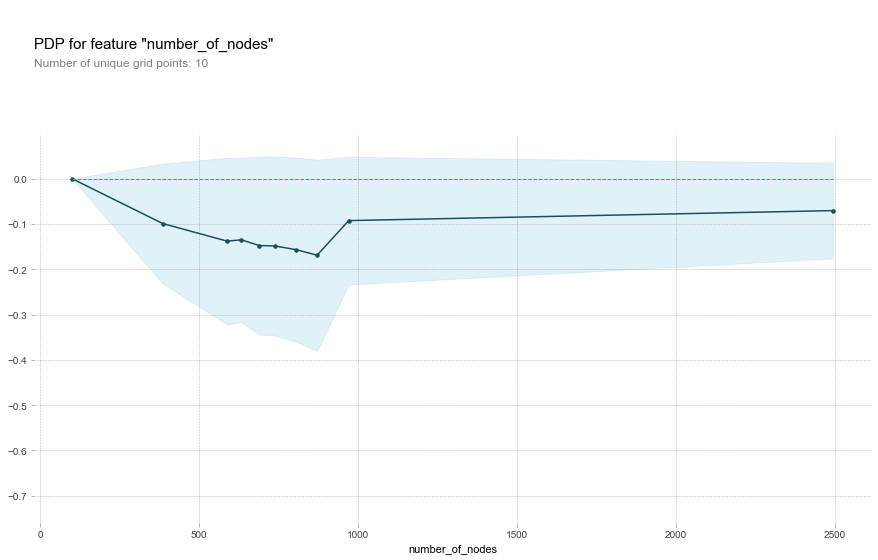

In [212]:
#对单个特征查看其局部依赖
base_features = dt_5.columns.values.tolist()
base_features.remove('balance')

feat_name = 'number_of_nodes'
pdp_dist = pdp.pdp_isolate(model=GBDT5, dataset=X_test5, model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()